In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, learning_curve
import matplotlib.pyplot as plt

### Data

In [2]:
# Load Data
train_df = pd.read_csv('preprocessed_train.csv')
test_df = pd.read_csv('preprocessed_test.csv')
val_df = pd.read_csv('preprocessed_val.csv')

In [3]:
# Clean Data (Removing NaN or invalid types)
train_df = train_df[train_df['text'].apply(type) != float].reset_index(drop=True)
test_df = test_df[test_df['text'].apply(type) != float].reset_index(drop=True)
val_df = val_df[val_df['text'].apply(type) != float].reset_index(drop=True)

In [4]:
train_df.head()

,text,sentiment
0,fuck bayless isoing,anger
1,make feel threatened,fear
2,dirty southern wanker,anger
3,omg peyton good enough help u playoff dumbass ...,surprise
4,need board create bit space name we’ll good,joy


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22829 entries, 0 to 22828
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       22829 non-null  object
 1   sentiment  22829 non-null  object
dtypes: object(2)
memory usage: 356.8+ KB


In [6]:
print(train_df['text'].apply(type).value_counts())

text
<class 'str'>    22829
Name: count, dtype: int64


### Data Processing

In [7]:
# Apply TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])
X_test = vectorizer.transform(test_df['text'])

In [8]:
# Encode Target Labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['sentiment'])
y_val = label_encoder.transform(val_df['sentiment'])
y_test = label_encoder.transform(test_df['sentiment'])

In [9]:
y_train

array([0, 2, 0, ..., 0, 3, 3])

### Modelling

In [10]:
# Train Logistic Regression Model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [11]:
# Validation
y_val_pred = logreg.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("Validation Accuracy: " + str(val_accuracy))
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_))

Validation Accuracy: 0.629382889200561
              precision    recall  f1-score   support

       anger       0.58      0.63      0.61       716
     disgust       0.56      0.26      0.35        97
        fear       0.75      0.40      0.53       104
         joy       0.71      0.78      0.74       923
     sadness       0.68      0.46      0.55       389
    surprise       0.54      0.61      0.57       623

    accuracy                           0.63      2852
   macro avg       0.64      0.52      0.56      2852
weighted avg       0.63      0.63      0.62      2852



In [12]:
# Test Evaluation
y_test_pred = logreg.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Test Accuracy: " + str(test_accuracy))
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

Test Accuracy: 0.6306400839454355
              precision    recall  f1-score   support

       anger       0.57      0.64      0.61       725
     disgust       0.70      0.27      0.39       123
        fear       0.89      0.40      0.55        98
         joy       0.70      0.79      0.74       857
     sadness       0.68      0.46      0.55       379
    surprise       0.57      0.62      0.59       677

    accuracy                           0.63      2859
   macro avg       0.68      0.53      0.57      2859
weighted avg       0.64      0.63      0.62      2859



In [13]:
k = 5
scores = cross_val_score(logreg, X_train, y_train, cv=k, scoring='accuracy')

print(f"Cross-Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-Validation Scores: [0.61782742 0.61870346 0.61651336 0.61279019 0.61270537]
Mean Accuracy: 0.6157 ± 0.0025


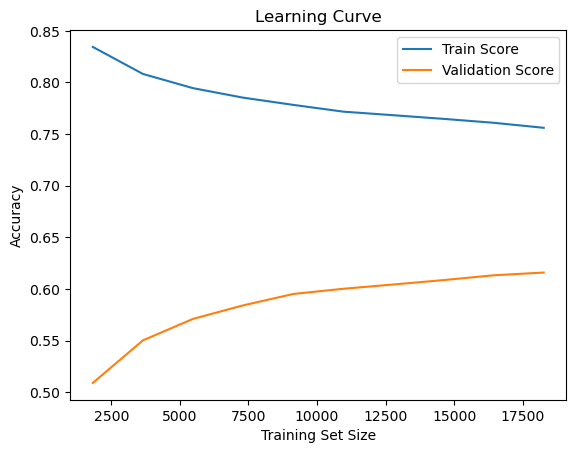

In [14]:
train_sizes, train_scores, val_scores = learning_curve(logreg, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation Score')
plt.legend()
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.show()

### Predicting

In [15]:
def predict_emotions(texts, model, vectorizer, label_encoder):
    """
    Predicts emotions for a list of text inputs.
    
    Args:
        texts (list): List of text strings to predict emotions for.
        model: Trained Logistic Regression model.
        vectorizer: Trained TF-IDF vectorizer.
        label_encoder: Trained label encoder for decoding emotion labels.
    
    Returns:
        List of predicted emotions.
    """
    X_input = vectorizer.transform(texts)
    predictions = model.predict(X_input)
    
    # Decode the numeric labels back to emotion strings
    predicted_emotions = label_encoder.inverse_transform(predictions)
    
    return predicted_emotions

In [16]:
texts = [
    "OMG! I just got a job offer today. I am so happy! Today is the best day", #joy
    "I never make her separate from me because i don t ever want her to feel like i m ashamed with her", #sadness
    "I cant walk into a shop anywhere where i do not feel uncomfortable", #fear
    "I am feeling outraged it shows everywhere. I can not belive he did that to me. This makes me so angry and frustrated.", #anger
]

# Predict emotions for the texts
predicted_emotions = predict_emotions(texts, logreg, vectorizer, label_encoder)

# Print the results
for text, emotion in zip(texts, predicted_emotions):
    print("Text: " + text)
    print(emotion)

Text: OMG! I just got a job offer today. I am so happy! Today is the best day
joy
Text: I never make her separate from me because i don t ever want her to feel like i m ashamed with her
anger
Text: I cant walk into a shop anywhere where i do not feel uncomfortable
anger
Text: I am feeling outraged it shows everywhere. I can not belive he did that to me. This makes me so angry and frustrated.
anger
